In [ ]:
!conda install -c conda-forge requests aiohttp -y

In [ ]:
import os,sys
sys.version
import aiohttp
from timer import timer
from multiprocessing import Pool
from concurrent.futures import ThreadPoolExecutor

In [ ]:
# %%time
import asyncio


URL='https://httpbin.org/uuid'

async def getdata(session,URL):
    async with session.get(URL) as response:
        responsefromserver = await response.json()
        print(responsefromserver['uuid'])


async def sample():
    # with requests.Session() as session:
    #     with ThreadPoolExecutor(max_workers=50) as executor:
    #         executor.map(getdata, [session]*100, [URL]*100)
    # with Pool() as pref:
    #     with requests.Session() as s:
    #         pref.starmap(getdata,[(s,URL) for _ in range(100)])
    for inx,item in enumerate(range(100)):
        async with aiohttp.Session() as s:
            tasks=[getdata(s,URL) for _ in range(100)]
            await asyncio.gather(*tasks)
            #  print(f'index {inx}-->{getdata(s,URL)}')

@timer(1,1)
def funcproc():
    asyncio.run(sample())


### Jina Base OPS

In [ ]:
from jina import Document,DocumentArray
import os
import sys
import glob
import time
import random
import datetime

In [ ]:
# !pip list | grep 'jina'
# !python -m jina auth login -f
# !python -m jina --version
# !python -m pip install ipywidgets
# !python -m pip install tensorflow
# !python -m pip install "finetuner[full]"
# !pip install -U pip setuptools wheel
# !pip install -U spacy
# !python -m spacy download en_core_web_md
# !pip install spacy_dbpedia_spotlight
# !pip install rdflib
# !pip install networkx

In [ ]:
imdb=DocumentArray().pull('tll-train-da',show_progress=True,local_cache=True)

In [ ]:
imdb.save('image_info_large.bin')

In [ ]:
import matplotlib.pyplot as plt
# plt.imshow(imdb[4].tensor)
imdb[4]

In [ ]:
import tensorflow as tf
tf.__version__

In [ ]:
from diagrams import Diagram
from diagrams.aws.compute import EC2

with Diagram("Simple Diagram",show=False) as gdb:
    EC2("web")

gdb    

In [ ]:
from diagrams import Diagram, Cluster
from diagrams.custom import Custom
from diagrams.aws.storage import SimpleStorageServiceS3Bucket

with Diagram("\r\r\Workflow is a pipeline where data is flow between various services", show=False, filename="custom_local", direction="LR") as gdb:
    
  cc_tweet = Custom('Twitter Datasource','./images/tweet_icon.jpg')
  cc_google_sheet = Custom('\r\rGoogle Sheet Datasource ','./images/Google_Sheets_logo.png')
  cc_git_actions = Custom(' Github Actions','./images/github_actions.png')  
  s3 = SimpleStorageServiceS3Bucket(label="S3 Bucket")

  cc_google_sheet << cc_git_actions << cc_tweet

  s3 <<  cc_git_actions << cc_google_sheet 

gdb

### Spacy Operations -- Named Entity Linking

In [ ]:
import spacy
import spacy_dbpedia_spotlight
from spacy.matcher import Matcher
nlp = spacy.load("en_core_web_trf")
nlp.add_pipe('dbpedia_spotlight')
doc = nlp("Joe Biden married Jill Tracy Jacobs, who was educated at the University of Delaware")
print([token.text for token in doc], sep=' ')


In [ ]:
print([token.lemma_ for token in doc], sep=' ')

In [ ]:
print([(token.lemma_, token.pos_) for token in doc], sep=' ')

In [ ]:
print([(token.lemma_, token.dep_) for token in doc], sep=' ')

In [ ]:
print([(ent.text, ent.label_) for ent in doc.ents], sep = ' ')

In [ ]:
print([ent.kb_id_ for ent in doc.ents])

In [ ]:
print("Before:", [token.text for token in doc])
ents = [ent for ent in doc.ents]
with doc.retokenize() as retokenizer:
    for i in range(len(ents)):
        retokenizer.merge(doc.ents[i])
print("After:", [token.text for token in doc])

In [ ]:
def get_relation(sent):
  aux = []
  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [[{'DEP' : 'ROOT'}],[{'DEP' : 'relcl'}],
            [{'POS' : 'VERB' }]]

  matcher.add("matching_1",pattern) 

  matches = matcher(doc)
  for x in matches:
    aux.append(doc[x[1]:x[2]].text)

  return(aux)

rels = get_relation("Joe Biden married Jill Tracy Jacobs, who was educated at the University of Delaware")
print(rels)

In [ ]:
from rdflib import Graph, URIRef, Literal, BNode
from rdflib.namespace import RDF, RDFS
from rdflib import Namespace
g = Graph()

for ent in doc.ents:
    # add the label of the entity
    g.add((URIRef(ent.kb_id_), RDFS.label, Literal(ent.text)))
    prev = URIRef(ent.kb_id_)

g.add((URIRef('http://dbpedia.org/resource/Joe_Biden'), URIRef("https://dbpedia.org/ontology/"+rels[0]), URIRef('http://dbpedia.org/resource/Jill_Tracy')))
g.add((URIRef('http://dbpedia.org/resource/Jill_Tracy'), URIRef("https://dbpedia.org/ontology/"+rels[1]), URIRef('http://dbpedia.org/resource/Delaware')))

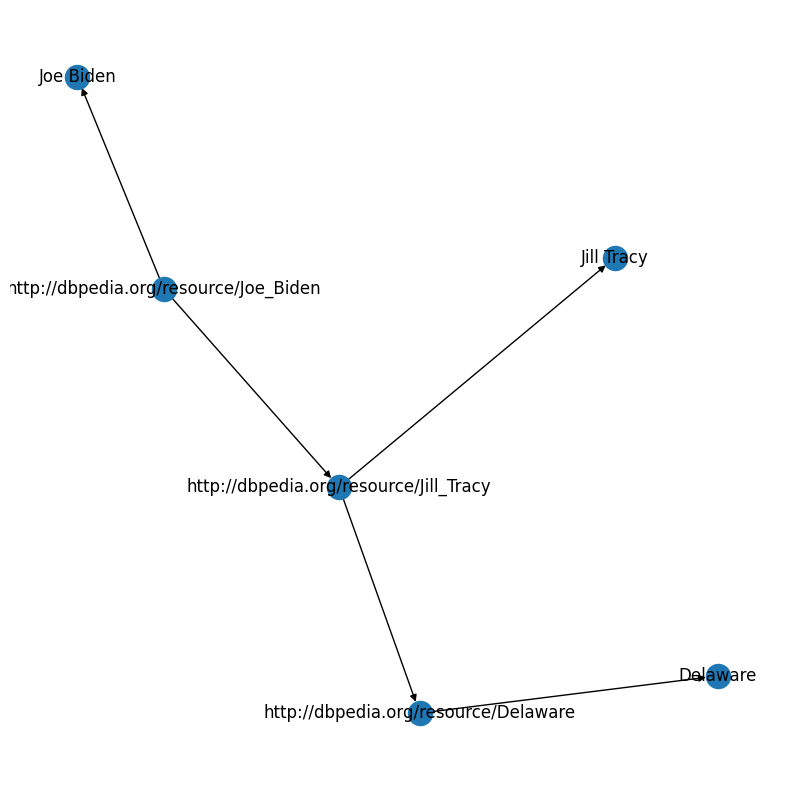

In [19]:
import rdflib
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
import networkx as nx
import matplotlib.pyplot as plt

G = rdflib_to_networkx_multidigraph(g)

# Plot Networkx instance of RDF Graph
pos = nx.spring_layout(G, scale=2)
edge_labels = nx.get_edge_attributes(G, 'r')
plt.figure(figsize=(10,10))
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
nx.draw(G, with_labels=True)
plt.show()